In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Exercise 4

In [2]:
np.random.seed(5030)
def box_muller(n):
    # Using Box-Muller
    # Only taking even n
    assert n%2 == 0
    unif = np.random.uniform(size = (n,))
    unif_1 = unif[::2]
    unif_2 = unif[1::2]
    normal_1 = np.sqrt(-2*np.log(unif_1))*np.cos(2*np.pi*unif_2)
    normal_2 = np.sqrt(-2*np.log(unif_1))*np.sin(2*np.pi*unif_2)
    normal = np.zeros((n,))
    normal[::2] = normal_1
    normal[1::2] = normal_2
    return normal

In log space,<br>
$dlog(S_t) = (r-\frac{\sigma^2}{2})dt + \sigma dW_t$

In [3]:
def euler_log(r, sigma, S0, K, T, n_time, n_path):
    dt = T/n_time

    Z = np.random.randn(n_path, n_time)
    log_increment = np.zeros(Z.shape)
    log_increment = log_increment + (r - sigma**2 / 2) * dt + sigma * np.sqrt(dt) * Z
    price = np.exp(np.log(S0) + np.sum(log_increment, axis = 1))

    # Following is the implementation of using box_muller but the computational cost is significantly larger for using a loop
    # log_price = np.ones((n_path,)) * np.log(S0)
    # for i in range(n_time):
    #     Z = box_muller(n_path)
    #     log_price = log_price + (r - sigma**2 / 2) * dt + sigma * np.sqrt(dt) * Z
    # price = np.exp(log_price)
    return price

def euler(r, sigma, S0, K, T, n_time, n_path):
    dt = T/n_time

    Z = np.random.randn(n_path, n_time)
    factor = np.ones(Z.shape)
    factor = factor * (1 + r * dt + sigma * np.sqrt(dt) * Z)
    price = S0 * np.prod(factor, axis = 1)

    # Following is the implementation of using box_muller but the computational cost is significantly larger for using a loop
    # price = np.ones((n_path,)) * S0
    # for i in range(n_time):
    #     Z = box_muller(n_path)
    #     price = price * (1 + r * dt + sigma * np.sqrt(dt) * Z)
    return price

In [4]:
r = 0.05
sigma = 0.2
S0 = 100
K = 100
T = 1

## Exercise 4.1

In [5]:
def black_scholes(S0=100, K=100, T=1, r=0.05, sigma=0.2, Call = True):
    from scipy.stats import norm
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    sign_ = 1 if Call else -1
    price = sign_ * (S0 * norm.cdf(sign_*d1) - K * np.exp(-r * T) * norm.cdf(sign_*d2))
    delta = sign_ * norm.cdf(sign_*d1)
    gamma = norm.pdf(d1)/(S0*sigma*np.sqrt(T))
    return price

def fixed_n_time(r, sigma, S0, K, T, n_time, n_paths):
    l = len(n_paths)
    option_price = np.zeros((l,))
    for i in tqdm(range(len(n_paths))):
        n_path = n_paths[i]
        stock_price = euler_log(r, sigma, S0, K, T, n_time, n_path)
        option_prices = np.where(stock_price - K > 0, stock_price - K, 0) * np.exp(-r*T)
        option_price[i] = np.mean(option_prices)

    return option_price

100%|██████████| 200/200 [00:07<00:00, 26.38it/s]


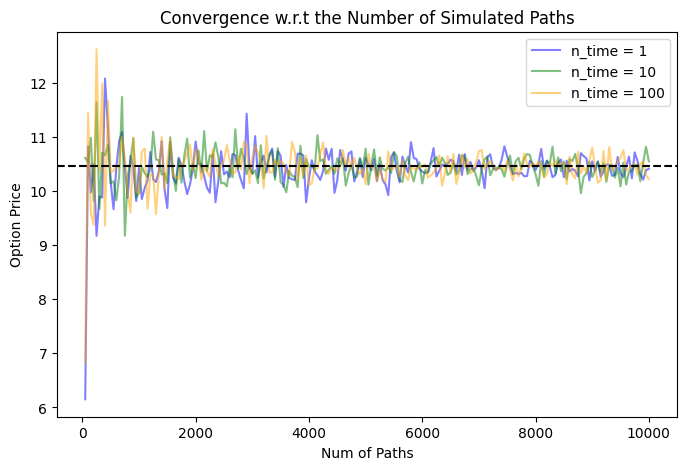

In [6]:
#n_paths = np.logspace(1.5, 4, num = 100, dtype = np.int_) //2 *2
n_paths = np.array(range(50, 10001, 50))

op_1 = fixed_n_time(r, sigma, S0, K, T, 1, n_paths)
op_10 = fixed_n_time(r, sigma, S0, K, T, 10, n_paths)
op_100 = fixed_n_time(r, sigma, S0, K, T, 100, n_paths)
bs_price = black_scholes()

plt.figure(figsize = (8, 5))
plt.plot(n_paths, op_1, color = 'blue', label='n_time = 1', alpha = 0.5)
plt.plot(n_paths, op_10, color = 'green', label='n_time = 10', alpha = 0.5)
plt.plot(n_paths, op_100, color = 'orange', label='n_time = 100', alpha = 0.5)
plt.axhline(bs_price, color='black',linestyle='--')

plt.xlabel('Num of Paths')
plt.ylabel('Option Price')
plt.title('Convergence w.r.t the Number of Simulated Paths')
plt.legend()
plt.show()

For small numbers of simulated paths, we should choose n_time = 100 because it deviates less from the theoretical option price; but for numbers of simulated paths sufficiently large, we should choose n_time = 10, because its variance is roughly the same as n_time = 100 but the computational cost is significantly smaller

## Exercise 4.2

In [7]:
def black_scholes(S0=100, K=100, T=1, r=0.05, sigma=0.2, Call = True):
    from scipy.stats import norm
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    sign_ = 1 if Call else -1
    price = sign_ * (S0 * norm.cdf(sign_*d1) - K * np.exp(-r * T) * norm.cdf(sign_*d2))
    delta = sign_ * norm.cdf(sign_*d1)
    gamma = norm.pdf(d1)/(S0*sigma*np.sqrt(T))
    return price

def fixed_n_path(r, sigma, S0, K, T, ns_time, n_path = 100000, use_log = False):
    l = len(ns_time)
    option_price = np.zeros((l,))
    for i in tqdm(range(len(ns_time))):
        n_time = ns_time[i]
        if use_log:
            stock_price = euler_log(r, sigma, S0, K, T, n_time, n_path)
        else:
            stock_price = euler(r, sigma, S0, K, T, n_time, n_path)
        option_prices = np.where(stock_price - K > 0, stock_price - K, 0) * np.exp(-r*T)
        option_price[i] = np.mean(option_prices)

    return option_price

100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


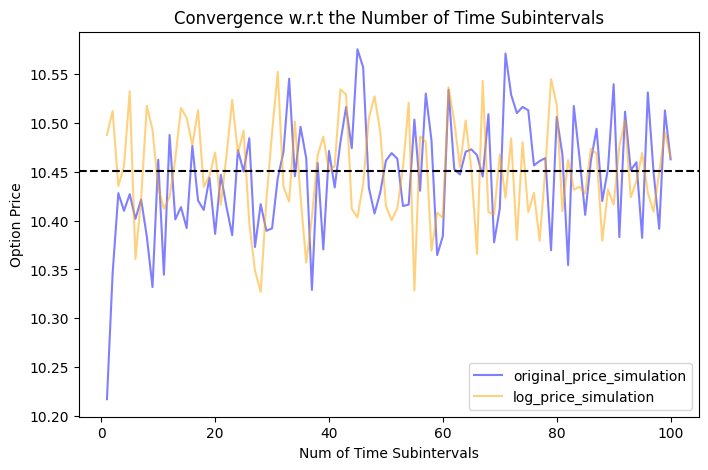

In [8]:
ns_time = np.array(range(1, 101))

op_1 = fixed_n_path(r, sigma, S0, K, T, ns_time, n_path = 100000, use_log = False)
op_2 = fixed_n_path(r, sigma, S0, K, T, ns_time, n_path = 100000, use_log = True)
bs_price = black_scholes()

plt.figure(figsize = (8, 5))
plt.plot(ns_time, op_1, color = 'blue', label='original_price_simulation', alpha = 0.5)
plt.plot(ns_time, op_2, color = 'orange', label='log_price_simulation', alpha = 0.5)
plt.axhline(bs_price, color='black',linestyle='--')

plt.xlabel('Num of Time Subintervals')
plt.ylabel('Option Price')
plt.title('Convergence w.r.t the Number of Time Subintervals')
plt.legend()
plt.show()

# Exercise 5

In [9]:
def straddle_cost(S0, sigma, r=0.05, K=100, T=0.5, use_antivar = False):
    n_path = 1000
    n_time = 100
    dt = T/n_time

    def option_price(r, sigma, S0, K, T, Z):
        log_increment = np.zeros(Z.shape)
        log_increment = log_increment + (r - sigma**2 / 2) * dt + sigma * np.sqrt(dt) * Z
        stock_price = np.exp(np.log(S0) + np.sum(log_increment, axis = 1))
        call = np.maximum(stock_price - K, 0) * np.exp(-r*T)
        put = np.maximum(K - stock_price, 0) * np.exp(-r*T)
        return call, put

    if use_antivar:
        Z = np.random.randn(n_path, n_time)
        Z_tilda = -Z
        c1, p1 = option_price(r, sigma, S0, K, T, Z)
        c2, p2 = option_price(r, sigma, S0, K, T, Z_tilda)
        c = np.mean((c1+c2)/2)
        p = np.mean((p1+p2)/2)
        return np.mean(c + p)
    else:
        Z = np.random.randn(2*n_path, n_time)
        call, put = option_price(r, sigma, S0, K, T, Z)
        return np.mean(call + put)

100%|██████████| 120/120 [00:02<00:00, 56.33it/s]


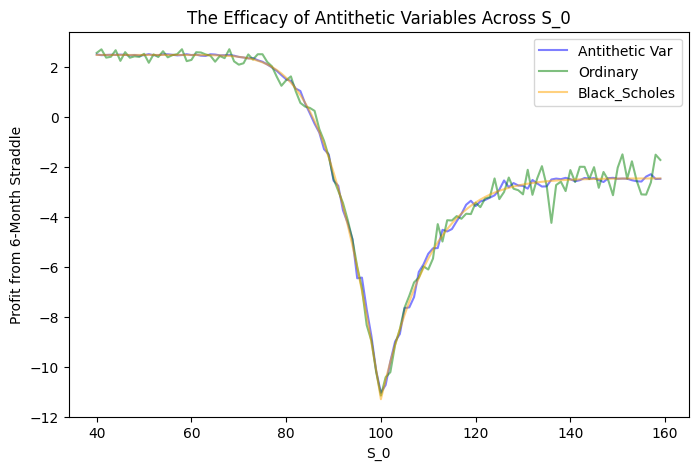

In [10]:
r = 0.05
sigma = 0.2
K = 100
T = 0.5
S0s = np.array(range(40, 160))
profit_w_antivar = []
profit_wo_antivar = []
theoretical_profit = []
for S0 in tqdm(S0s):
    p = np.absolute(S0 - K)
    c1 = straddle_cost(S0, sigma, use_antivar = True)
    c2 = straddle_cost(S0, sigma, use_antivar = False)
    c3 = black_scholes(S0=S0, sigma=sigma, T=0.5, Call = True) + black_scholes(S0=S0, sigma=sigma, T=0.5, Call = False)
    profit_w_antivar.append(p - c1)
    profit_wo_antivar.append(p - c2)
    theoretical_profit.append(p - c3)

profit_w_antivar = np.array(profit_w_antivar)
profit_wo_antivar = np.array(profit_wo_antivar)
theoretical_profit = np.array(theoretical_profit)

plt.figure(figsize = (8, 5))
plt.plot(S0s, profit_w_antivar, color = 'blue', label='Antithetic Var', alpha = 0.5)
plt.plot(S0s, profit_wo_antivar, color = 'green', label='Ordinary', alpha = 0.5)
plt.plot(S0s, theoretical_profit, color = 'orange', label='Black_Scholes', alpha = 0.5)

plt.xlabel('S_0')
plt.ylabel('Profit from 6-Month Straddle')
plt.title('The Efficacy of Antithetic Variables Across S_0')
plt.legend()
plt.show()

100%|██████████| 50/50 [00:01<00:00, 45.68it/s]


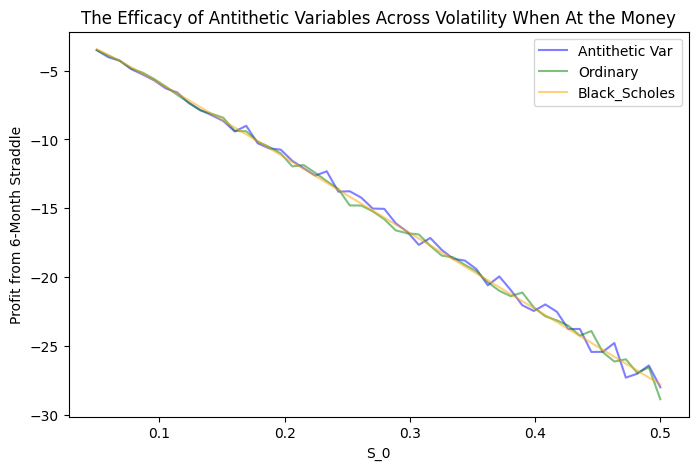

In [11]:
r = 0.05
sigmas = np.linspace(0.05, 0.5, 50)
K = 100
T = 0.5
S0 = 100
profit_w_antivar = []
profit_wo_antivar = []
theoretical_profit = []
for sigma in tqdm(sigmas):
    p = np.absolute(S0 - K)
    c1 = straddle_cost(S0, sigma, use_antivar = True)
    c2 = straddle_cost(S0, sigma, use_antivar = False)
    c3 = black_scholes(S0=S0, sigma=sigma, T=0.5, Call = True) + black_scholes(S0=S0, sigma=sigma, T=0.5, Call = False)
    profit_w_antivar.append(p - c1)
    profit_wo_antivar.append(p - c2)
    theoretical_profit.append(p - c3)

profit_w_antivar = np.array(profit_w_antivar)
profit_wo_antivar = np.array(profit_wo_antivar)
theoretical_profit = np.array(theoretical_profit)

plt.figure(figsize = (8, 5))
plt.plot(sigmas, profit_w_antivar, color = 'blue', label='Antithetic Var', alpha = 0.5)
plt.plot(sigmas, profit_wo_antivar, color = 'green', label='Ordinary', alpha = 0.5)
plt.plot(sigmas, theoretical_profit, color = 'orange', label='Black_Scholes', alpha = 0.5)

plt.xlabel('S_0')
plt.ylabel('Profit from 6-Month Straddle')
plt.title('The Efficacy of Antithetic Variables Across Volatility When At the Money')
plt.legend()
plt.show()

100%|██████████| 50/50 [00:01<00:00, 26.40it/s]


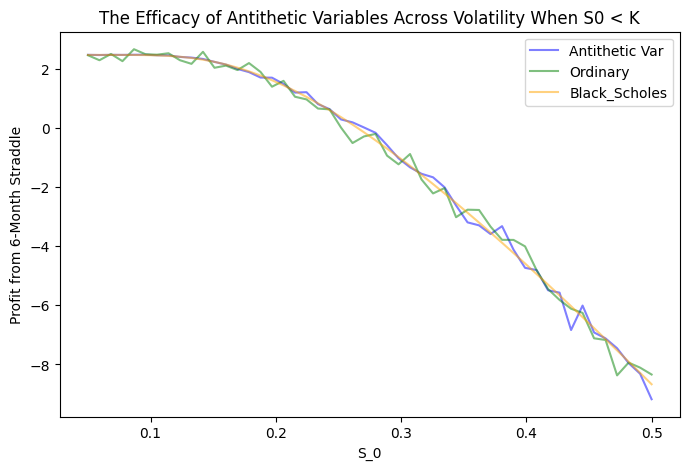

In [12]:
r = 0.05
sigmas = np.linspace(0.05, 0.5, 50)
K = 100
T = 0.5
S0 = 80
profit_w_antivar = []
profit_wo_antivar = []
theoretical_profit = []
for sigma in tqdm(sigmas):
    p = np.absolute(S0 - K)
    c1 = straddle_cost(S0, sigma, use_antivar = True)
    c2 = straddle_cost(S0, sigma, use_antivar = False)
    c3 = black_scholes(S0=S0, sigma=sigma, T=0.5, Call = True) + black_scholes(S0=S0, sigma=sigma, T=0.5, Call = False)
    profit_w_antivar.append(p - c1)
    profit_wo_antivar.append(p - c2)
    theoretical_profit.append(p - c3)

profit_w_antivar = np.array(profit_w_antivar)
profit_wo_antivar = np.array(profit_wo_antivar)
theoretical_profit = np.array(theoretical_profit)

plt.figure(figsize = (8, 5))
plt.plot(sigmas, profit_w_antivar, color = 'blue', label='Antithetic Var', alpha = 0.5)
plt.plot(sigmas, profit_wo_antivar, color = 'green', label='Ordinary', alpha = 0.5)
plt.plot(sigmas, theoretical_profit, color = 'orange', label='Black_Scholes', alpha = 0.5)

plt.xlabel('S_0')
plt.ylabel('Profit from 6-Month Straddle')
plt.title('The Efficacy of Antithetic Variables Across Volatility When S0 < K')
plt.legend()
plt.show()

100%|██████████| 50/50 [00:00<00:00, 62.82it/s]


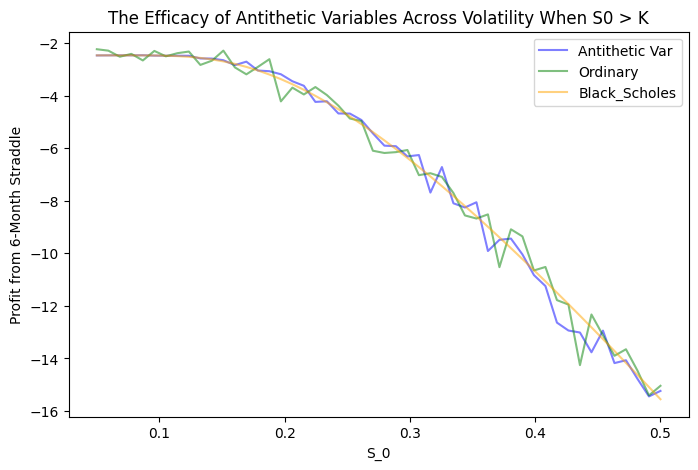

In [13]:
r = 0.05
sigmas = np.linspace(0.05, 0.5, 50)
K = 100
T = 0.5
S0 = 120
profit_w_antivar = []
profit_wo_antivar = []
theoretical_profit = []
for sigma in tqdm(sigmas):
    p = np.absolute(S0 - K)
    c1 = straddle_cost(S0, sigma, use_antivar = True)
    c2 = straddle_cost(S0, sigma, use_antivar = False)
    c3 = black_scholes(S0=S0, sigma=sigma, T=0.5, Call = True) + black_scholes(S0=S0, sigma=sigma, T=0.5, Call = False)
    profit_w_antivar.append(p - c1)
    profit_wo_antivar.append(p - c2)
    theoretical_profit.append(p - c3)

profit_w_antivar = np.array(profit_w_antivar)
profit_wo_antivar = np.array(profit_wo_antivar)
theoretical_profit = np.array(theoretical_profit)

plt.figure(figsize = (8, 5))
plt.plot(sigmas, profit_w_antivar, color = 'blue', label='Antithetic Var', alpha = 0.5)
plt.plot(sigmas, profit_wo_antivar, color = 'green', label='Ordinary', alpha = 0.5)
plt.plot(sigmas, theoretical_profit, color = 'orange', label='Black_Scholes', alpha = 0.5)

plt.xlabel('S_0')
plt.ylabel('Profit from 6-Month Straddle')
plt.title('The Efficacy of Antithetic Variables Across Volatility When S0 > K')
plt.legend()
plt.show()

**Comment**:<br>
Given the same volatility, the further the initial price is from the strike price, the more effective adding antithetic variables is. Monte Carlo predictor with antithetic variables maintains rougly the same level of variance across different levels of moneyness; but the variance of ordinary Monte Carlo predictor increases as the initial price moves further from the strick price.<br>
Given the same level of moneyness, when volatility is small, adding antithetic variables is more effective than ordinary Monte Carlo, but as volatility increases, the effect of adding antithetic variables becomes less and less obvious. The variances of both predictors become larger as volatility increases.